In [1]:
from PIL import Image
import os

def create_blank_image(n,m, folder_path, file_name="blank_map.png"):
    os.makedirs(folder_path, exist_ok=True)
    image = Image.new("RGB", (n, m), color=(255, 255, 255))  # white background
    
    file_path = os.path.join(folder_path, file_name)
    image.save(file_path)
    
    print(f"Blank image saved at {file_path}")

# Example usage:
# create_blank_image(2000,2000, "/mnt/Personal/Projects/Micromouse/Playground/map_images",file_name="blank_map.png")


In [2]:
image_name ="random_squid.png"
# image_name ="test.png"

In [3]:
from PIL import Image
import numpy as np

def process_image(image_path):
    # Open image
    img = Image.open(image_path).convert("RGB")
    width, height = img.size
    print(f"Image size: {width} x {height}")
    
    # Convert image to numpy array
    img_array = np.array(img)
    
    # Reshape to a list of RGB tuples
    pixels = img_array.reshape(-1, 3)
    
    # Find unique colors
    unique_colors, indices = np.unique(pixels, axis=0, return_inverse=True)
    
    # Display unique colors with labels
    print("Unique colors and their labels:")
    for idx, color in enumerate(unique_colors):
        print(f"Label {idx}: RGB {tuple(color)}")
    
    # Map to labels
    label_matrix = indices.reshape(img_array.shape[:2])
    

# Example usage
process_image("/mnt/Personal/Projects/Micromouse/Playground/map_images/"+image_name)




Image size: 2000 x 2000
Unique colors and their labels:
Label 0: RGB (np.uint8(0), np.uint8(0), np.uint8(0))
Label 1: RGB (np.uint8(0), np.uint8(38), np.uint8(255))
Label 2: RGB (np.uint8(255), np.uint8(0), np.uint8(0))
Label 3: RGB (np.uint8(255), np.uint8(255), np.uint8(255))


In [4]:
from PIL import Image
import numpy as np

def process_and_find_isolated(image_path, color0, color1, color2, color3):
    # Open and convert image
    img = Image.open(image_path).convert("RGB")
    width, height = img.size
    print(f"Image size: {width} x {height}")

    img_array = np.array(img)
    label_matrix = np.full((height, width), 3, dtype=np.uint8)

    # Assign labels
    mask0 = np.all(img_array == color0, axis=2)
    mask1 = np.all(img_array == color1, axis=2)
    mask2 = np.all(img_array == color2, axis=2)
    mask3 = np.all(img_array == color3, axis=2)

    label_matrix[mask0] = 0
    label_matrix[mask1] = 1
    label_matrix[mask2] = 2
    label_matrix[mask3] = 3

    # Find and print isolated points
    isolated_points = []

    for i in range(height):
        for j in range(width):
            val = label_matrix[i, j]
            if val in (0, 1, 2):
                count_same = 0
                # Check 8 neighbors
                for di in [-1, 0, 1]:
                    for dj in [-1, 0, 1]:
                        if di == 0 and dj == 0:
                            continue
                        ni, nj = i + di, j + dj
                        if 0 <= ni < height and 0 <= nj < width:
                            if label_matrix[ni, nj] == val:
                                count_same += 1
                if count_same == 1:
                    isolated_points.append((i, j))

    print(f"Isolated points (with exactly 1 same neighbor): {isolated_points}")
    return label_matrix, isolated_points

# Example usage
matrix, points = process_and_find_isolated(
    "/mnt/Personal/Projects/Micromouse/Playground/map_images/"+image_name,
    color0=(0, 0, 0),    # black
    color1=(255, 0, 0),    
    color2=(0, 38, 255),     
    color3=(255, 255, 255)     # white
)

print("Final label matrix:")

matrix = matrix[::-1].T




Image size: 2000 x 2000
Isolated points (with exactly 1 same neighbor): [(1674, 1638), (1706, 112), (1738, 204), (1748, 1758), (1754, 340), (1756, 1688), (1786, 1532)]
Final label matrix:


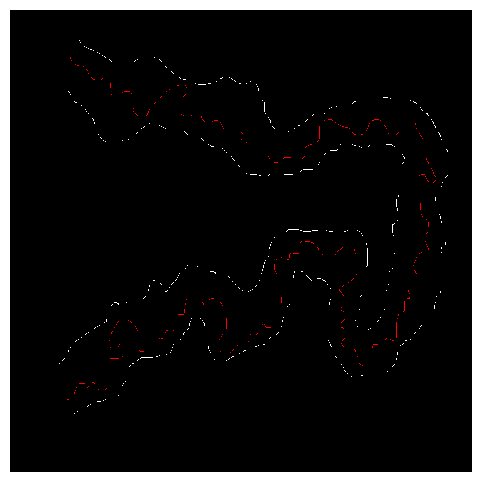

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def display_matrix_with_colors(matrix):
    # Create a color map: 0 -> red, 1 -> white, 2 -> white, 3 -> black
    color_map = {
        0: [1, 0, 0],      # red
        1: [1, 1, 1],      # white
        2: [1, 1, 1],      # white
        3: [0, 0, 0],      # black
    }

    # Create RGB image array
    height, width = matrix.shape
    rgb_image = np.zeros((height, width, 3))

    for value, color in color_map.items():
        mask = (matrix == value)
        rgb_image[mask] = color

    # Display the image
    plt.figure(figsize=(6, 6))
    plt.imshow(rgb_image, interpolation='nearest')
    plt.axis('off')
    plt.show()

display_matrix_with_colors(matrix)


In [6]:
import numpy as np

def invert_zero_one(matrix,replacer):
    matrix = np.array(matrix)
    # Create new matrix: where original is 0 -> 1, else -> 0
    new_matrix = np.where(matrix == replacer, 1, 0)
    return new_matrix

path_shape = matrix.shape
path_0 = invert_zero_one(matrix,replacer=0)
path_1 = invert_zero_one(matrix,replacer=1)
path_2 = invert_zero_one(matrix,replacer=2)


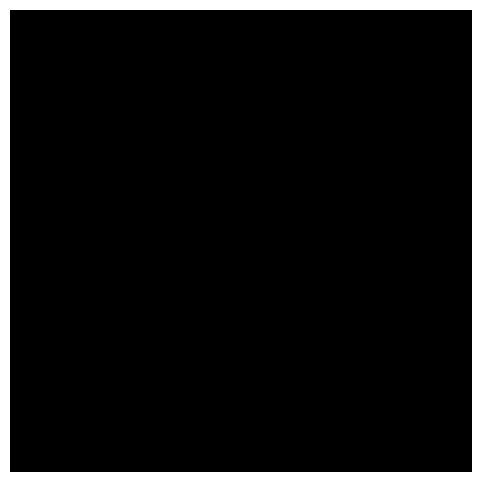

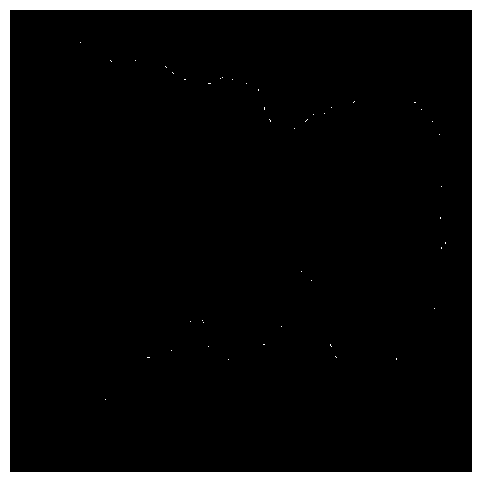

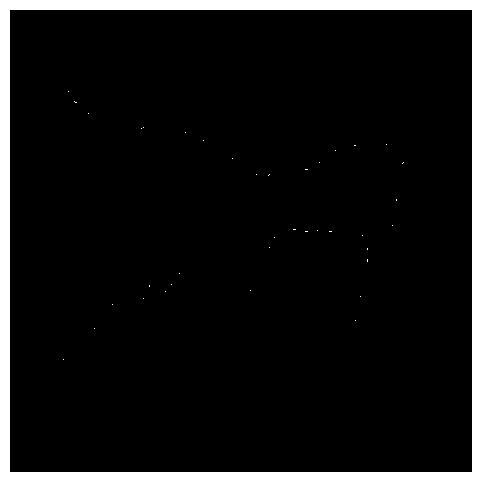

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def find_path_constraints(matrix, side):
    matrix = np.array(matrix)
    search_matrix = np.zeros_like(matrix, dtype=bool)
    constraint_points = []

    h, w = matrix.shape
    ef_ss = (side - 1) // 2

    # Find initial org point: 1 with only one neighboring 1
    def count_neighbors(i, j):
        count = 0
        for dx in [-1, 0, 1]:
            for dy in [-1, 0, 1]:
                if dx == 0 and dy == 0:
                    continue
                ni, nj = i + dx, j + dy
                if 0 <= ni < h and 0 <= nj < w:
                    if matrix[ni, nj] == 1:
                        count += 1
        return count

    org = None
    for i in range(h):
        for j in range(w):
            if matrix[i, j] == 1 and count_neighbors(i, j) == 1:
                org = (i, j)
                break
        if org:
            break

    if not org:
        print("No suitable starting point found.")
        return constraint_points
    
    
    constraint_points.append(org)

    while True:
        i, j = org
        search_matrix[i, j] = True



        # Search boundary points
        found_next = False
        for dx in [-ef_ss, ef_ss]:
            for dy in range(-ef_ss, ef_ss + 1):
                ni, nj = i + dx, j + dy
                if 0 <= ni < h and 0 <= nj < w:
                    if matrix[ni, nj] == 1 and not search_matrix[ni, nj]:
                        constraint_points.append((ni, nj))
                        org = (ni, nj)
                        found_next = True
                        break
            if found_next:
                break

        if not found_next:
            for dy in [-ef_ss, ef_ss]:
                for dx in range(-ef_ss, ef_ss + 1):
                    ni, nj = i + dx, j + dy
                    if 0 <= ni < h and 0 <= nj < w:
                        if matrix[ni, nj] == 1 and not search_matrix[ni, nj]:
                            constraint_points.append((ni, nj))
                            org = (ni, nj)
                            found_next = True
                            break
                if found_next:
                    break

        if not found_next:
            break  # No more points on boundary
        
                # Mark square of side
        for dx in range(-ef_ss, ef_ss + 1):
            for dy in range(-ef_ss, ef_ss + 1):
                ni, nj = i + dx, j + dy
                if 0 <= ni < h and 0 <= nj < w:
                    search_matrix[ni, nj] = True

    # Plotting
    display_matrix = np.zeros((h, w, 3))  # RGB

    for x, y in constraint_points:
        display_matrix[x, y] = [1, 1, 1]  # white

    display_matrix[display_matrix.sum(axis=2) == 0] = [0, 0, 0]  # black

    plt.figure(figsize=(6, 6))
    plt.imshow(display_matrix, interpolation='nearest')
    plt.axis('off')
    plt.show()

    return constraint_points

# matrix = [
#     [0, 0, 0, 0, 0],
#     [0, 1, 1, 1, 0],
#     [0, 0, 0, 1, 0],
#     [0, 0, 0, 1, 0],
#     [0, 0, 0, 0, 0]
# ]

side = 10
point_0 = find_path_constraints(path_0, side)
point_1 = find_path_constraints(path_1, side)
point_2 = find_path_constraints(path_2, side)

# print("Constraint points:", point_0)



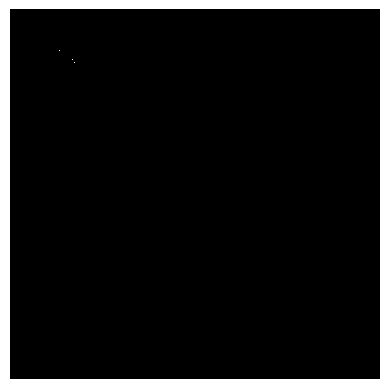

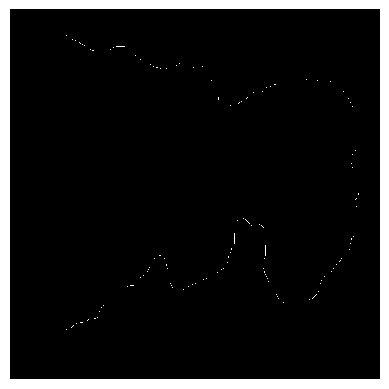

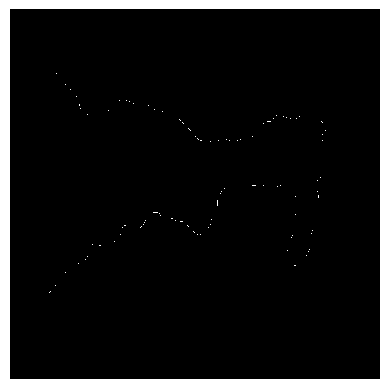

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def bresenham_line(x0, y0, x1, y1):
    """Generate points on a line from (x0,y0) to (x1,y1) using Bresenham's algorithm."""
    points = []
    dx = abs(x1 - x0)
    dy = abs(y1 - y0)
    sx = 1 if x0 < x1 else -1
    sy = 1 if y0 < y1 else -1
    err = dx - dy

    while True:
        points.append((x0, y0))
        if x0 == x1 and y0 == y1:
            break
        e2 = 2 * err
        if e2 > -dy:
            err -= dy
            x0 += sx
        if e2 < dx:
            err += dx
            y0 += sy
    return points

def draw_lines_matrix(points, shape):
    matrix = np.zeros(shape, dtype=np.uint8)

    for i in range(len(points) - 1):
        (x0, y0) = points[i]
        (x1, y1) = points[i + 1]
        line_points = bresenham_line(x0, y0, x1, y1)
        for x, y in line_points:
            if 0 <= x < shape[0] and 0 <= y < shape[1]:
                matrix[x, y] = 1

    plt.imshow(matrix, cmap='gray', interpolation='nearest')
    plt.axis('off')
    plt.show()

    return matrix

# points = [(2, 2), (7, 5), (7, 10), (2, 12)]
# shape = (15, 15)

smooth_0 = draw_lines_matrix(point_0, path_shape)
smooth_1 = draw_lines_matrix(point_1, path_shape)
smooth_2 = draw_lines_matrix(point_2, path_shape)
# print(result_matrix)



In [9]:
import numpy as np

def direc_flipper(direc):
    direc = direc-1
    direc = (direc+4) % 8
    direc = direc+1

    return direc

def trace_path(matrix, start_i, start_j, line_type):
    shape = matrix.shape
    dtype = np.dtype([('flag', np.bool_), ('prev', np.uint16),
                      ('succ', np.uint16), ('line_type', np.uint8)])
    
    map_matrix = np.full(shape, np.array((False, 0, 0, 3), dtype=dtype), dtype=dtype)
    map_matrix[start_i, start_j]['flag'] = True
    map_matrix[start_i, start_j]['line_type'] = line_type
    
    elem_array = [
        (0, 0), (0, 1), (1, 1), (1, 0), (1, -1),
        (0, -1), (-1, -1), (-1, 0), (-1, 1)
    ]
    
    direc=0
    prev_direc=0
    
    org_i, org_j = start_i, start_j
    
    while True:
        found = False
        for di, dj in elem_array[1:]:  # skip (0,0)
            ni, nj = org_i + di, org_j + dj
            if 0 <= ni < shape[0] and 0 <= nj < shape[1]:
                if matrix[ni, nj] == 1 and not map_matrix[ni, nj]['flag']:
                    # Mark successor direction
                    direc = elem_array.index((di, dj))
                    
                    
                    # Mark new point
                    map_matrix[org_i, org_j]['flag'] = True
                    map_matrix[org_i, org_j]['line_type'] = line_type
                    map_matrix[org_i, org_j]['succ'] = direc
                    map_matrix[org_i, org_j]['prev'] = prev_direc
                    
                    prev_direc=direc_flipper(direc)
                    # Move origin
                    org_i, org_j = ni, nj
                    found = True
                    break
        if not found:
            break
        
    map_matrix[org_i, org_j]['flag'] = True
    map_matrix[org_i, org_j]['line_type'] = line_type
    map_matrix[org_i, org_j]['succ'] = 0
    map_matrix[org_i, org_j]['prev'] = prev_direc
    
    return map_matrix


origin_0 = point_0[0]
origin_1 = point_1[0]
origin_2 = point_2[0]

map_0 = trace_path(smooth_0,origin_0[0],origin_0[1],0)
map_1 = trace_path(smooth_1,origin_1[0],origin_1[1],1)
map_2 = trace_path(smooth_2,origin_2[0],origin_2[1],2)


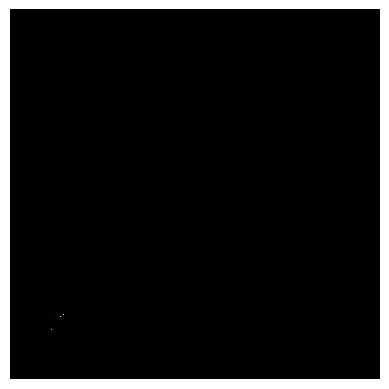

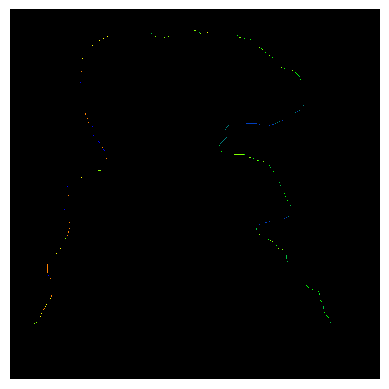

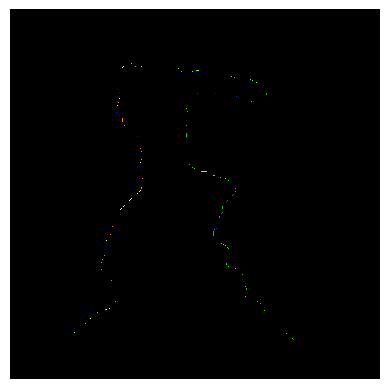

In [10]:
import numpy as np
import matplotlib.pyplot as plt

def display_colored_matrix(matrix):
    
    matrix = matrix = matrix.T[::-1]

    shape = matrix.shape
    color_matrix = np.zeros((shape[0], shape[1], 3))  # RGB image
    
    # Define colors for 0-9 (you can customize these)
    color_list = [
        [1.0, 0.0, 0.0],  # red
        [1.0, 0.5, 0.0],  # orange-ish
        [1.0, 1.0, 0.0],  # yellow
        [0.5, 1.0, 0.0],  # yellow-green
        [0.0, 1.0, 0.0],  # green
        [0.0, 0.75, 0.25],
        [0.0, 0.5, 0.5],
        [0.0, 0.25, 0.75],
        [0.0, 0.0, 1.0],  # blue
        [0.0, 0.0, 1.0],  # blue (final)
    ]


    
    for i in range(shape[0]):
        for j in range(shape[1]):
            flag, prev,succ,line_type = matrix[i, j]
            if flag:
                color_matrix[i, j] = color_list[succ % 10]
            else:
                color_matrix[i, j] = [0, 0, 0]  # black
    
    plt.imshow(color_matrix, interpolation='nearest')
    plt.axis('off')
    plt.show()
    
display_colored_matrix(map_0)
display_colored_matrix(map_1)
display_colored_matrix(map_2)

In [ ]:
import numpy as np

def combine_matrices(mat1, mat2, mat3):
    shape = mat1.shape
    dtype = mat1.dtype
    combined = np.zeros(shape, dtype=dtype)
    
    default_value = (False, 0, 0, 3)

    for i in range(shape[0]):
        for j in range(shape[1]):
            if mat1[i, j][0]:
                combined[i, j] = mat1[i, j]
            elif mat2[i, j][0]:
                combined[i, j] = mat2[i, j]
            elif mat3[i, j][0]:
                combined[i, j] = mat3[i, j]
            else:
                combined[i, j] = default_value

    return combined

def index_to_point(ij, min_dist=0.1):
    
    i,j = ij[0],ij[1]

    i, j = i*min_dist, j*min_dist

    return (i, j)

map_matrix = combine_matrices(map_0,map_1,map_2)
display_colored_matrix(map_matrix)

origin_0 = index_to_point(origin_0)
origin_1 = index_to_point(origin_1)
origin_2 = index_to_point(origin_2)

origins=[origin_0,origin_1,origin_2]
print(origins)

In [ ]:
np.save('/mnt/Personal/Projects/Micromouse/Playground/map_images/matrix_file.npy', map_matrix)
np.save('/mnt/Personal/Projects/Micromouse/Playground/map_images/origin_file.npy', origins)